In [9]:
# Pygame cell

import pygame
import numpy as np
import math
import noise
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# np.random.seed(23)

# Global constants
WIDTH, HEIGHT = 400, 400
GRID_SIZE = 20
ROBOT_SIZE = 3
FORWARD_SPEED = 3
TURN_SPEED = 0.5
NUM_RAYS = 4
RAY_LENGTH = 60
NUM_ROBOTS = 20
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)

class MapBelief():
    def __init__(self, init_map, sensor_noise):
        self.map = init_map
        self.landmark_beliefs = [] # Array of (mu, cov) pairs
        self.sensor_noise = sensor_noise

    def likelihood(self, landmark):
        l = 0
        id = 0
        max_like = -1
        min_dist = np.inf
        for i, (mu, cov) in enumerate(self.landmark_beliefs):
            maha_dist = (landmark - mu).T @ np.linalg.inv(cov + self.sensor_noise) @ (landmark - mu)
            if maha_dist < min_dist:
                min_dist = maha_dist
                id = i

        l = min_dist
        return l, id

    def get_landmark_params(self, id):
        return self.landmark_beliefs[id]

    def set_landmark_params(self, id, params):
        self.landmark_beliefs[id] = params

    def add_landmark(self, params):
        self.landmark_beliefs.append(params)

    def draw_map(self, iter):
        def gaussian_2d(x, y, mean, cov):
            pos = np.stack([x, y], axis=-1)
            inv_cov = np.linalg.inv(cov)
            diff = pos - mean
            exponent = np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
            g = np.exp(-0.5 * exponent) 
            # print(np.max(g))
            return g / np.max(g)

        # Create grid
        grid_cols, grid_rows = WIDTH // GRID_SIZE, HEIGHT // GRID_SIZE
        gs = 256
        x_vals = np.linspace(-2, grid_cols + 2, gs)
        y_vals = np.linspace(-2, grid_rows + 2, gs)
        x, y = np.meshgrid(x_vals, y_vals)

        # Example: list of (mean, covariance) pairs
        gaussians = self.landmark_beliefs
        print("Landmarks:", self.landmark_beliefs)

        # Initialize heatmap
        heatmap = np.zeros((gs, gs))

        # Add each Gaussian to the heatmap
        for mean, cov in gaussians:
            heatmap += gaussian_2d(x, y, mean, cov)
        # heatmap = heatmap / np.max(heatmap)

        print("\n\n", heatmap)

        # Plot
        plt.imshow(heatmap, extent=[0, grid_cols, 0, grid_rows], origin='upper', cmap='Greys')
        # plt.colorbar(label='Intensity')
        plt.title('Map Belief')
        plt.xlabel('c')
        plt.ylabel('r')
        plt.savefig(f'results/map{iter}.jpg')
        plt.close()

    # Kalman Filter
    def update_belief(self, mu, cov, z_t):
        # Update belief; estimate new state.
        C_t = np.eye(2)
        Q_t = self.sensor_noise
        A_t = np.eye(2)
        R_t = np.eye(2) * 1e-2

        # Prediction step. NOTE: assuming landmarks do not move
        mu_bar_next = (A_t @ mu)
        cov_bar_next = (A_t @ (cov @ A_t.T)) + R_t
        # Kalman gain
        K_t = cov_bar_next @ (C_t.T @ np.linalg.inv((C_t @ (cov_bar_next @ C_t.T)) + Q_t))
        # Correction step
        mu_next = mu_bar_next + (K_t @ (z_t - (C_t @ mu_bar_next)))
        # lower bound covariance
        cov_next = np.maximum((np.eye(2) - (K_t @ C_t)) @ cov_bar_next, np.eye(2)*1e-2)

        return mu_next, cov_next

    def map_update(self, obv):
        # Update and add new observations
        # Loop over all observed landmarks
        thresh = 5.99
        l, id = self.likelihood(obv)
        if l < thresh:
            mu, cov = self.get_landmark_params(id)
            # Kalman update
            mu_new, cov_new = self.update_belief(mu, cov, obv)
            self.set_landmark_params(id, (mu_new, cov_new))
        else:
            # Add to map_belief.landmark_beliefs
            params = (obv, np.eye(2)*4e-1)
            self.add_landmark(params)

# pygame initialization
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
clock = pygame.time.Clock()

def generate_occupancy_grid(width, height, scale=0.1, threshold=0.5):
    grid = np.zeros((height, width), dtype=int)
    seed = int(np.random.uniform(0,500))
    for y in range(height):
        for x in range(width):
            # Fill in square with perlin noise (like minecraft)
            value = noise.pnoise2(x * scale, y * scale, octaves=4, persistence=0.5, lacunarity=2.0, repeatx=width, repeaty=height, base=seed)
            grid[y, x] = 1 if value < threshold else 0

    # Fill in the boundary so robots don't run away
    grid[0, :] = 1
    grid[-1, :] = 1
    grid[:, 0] = 1
    grid[:, -1] = 1
    return grid

# Map from continuous screen space to discrete grid map space
def grid_to_screen(x, y):
    return x * GRID_SIZE, y * GRID_SIZE

# An individual robot agent
class Robot:
    grid_cols, grid_rows = WIDTH // GRID_SIZE, HEIGHT // GRID_SIZE
    obstacle_grid = generate_occupancy_grid(grid_cols,grid_rows,scale=0.08,threshold=-0.07)
    belief_grid = MapBelief(np.zeros((grid_rows, grid_cols)),  np.eye(2) * 8e-2)
    sensor_n = np.eye(2) * 1e-3

    def __init__(self, x, y, angle, speed):
        self.x = x
        self.y = y
        self.angle = angle
        self.vel_x = speed
        self.vel_y = 0

        #separate x and y speeds correspoinding to anti-consensus behavior, 
        # to be combined with original behavior during update
        self.xspeed = 0
        self.yspeed = 0

    # Detect if objects are in front, to the side, how far away, etc...
    def cast_rays(self, grid):
        distances = []
        for i in range(-NUM_RAYS // 2, NUM_RAYS // 2 + 1):
            ray_angle = self.angle + (i / NUM_RAYS) * math.pi / 2
            dist, is_hit = self.get_ray_distance(grid, ray_angle)
            distances.append((ray_angle, dist, is_hit))
        return distances

    # Get distance for intersection of ray and obstacle
    def get_ray_distance(self, grid, angle):
        for d in range(RAY_LENGTH):
            check_x = int((self.x + math.cos(angle) * d) / GRID_SIZE)
            check_y = int((self.y + math.sin(angle) * d) / GRID_SIZE)
            if 0 <= check_x < grid.shape[1] and 0 <= check_y < grid.shape[0]:
                if grid[check_y, check_x] == 1:
                    return d, True
        # false if no landmark detected
        return RAY_LENGTH, False

    # TODO: Should the noise be constant??
    def update(self):
        distances = self.cast_rays(Robot.obstacle_grid)
        left_dist = distances[0][1]
        right_dist = distances[-1][1]
        for ang, d, is_hit in distances:
            if not is_hit:
                continue
            meas = np.array([int((self.x + math.cos(ang) * d) / GRID_SIZE), int((self.y + math.sin(ang) * d) / GRID_SIZE)])
            Robot.belief_grid.map_update(np.random.multivariate_normal(meas, Robot.sensor_n))

        # turn if detected object is close enough
        if left_dist < 30:
            self.angle += TURN_SPEED
            self.xspeed = 0
            self.yspeed = 0
        elif right_dist < 30:
            self.angle -= TURN_SPEED
            self.xspeed = 0
            self.yspeed=0

        # Move forward + Added bias for anti-consensus
        self.x += math.cos(self.angle) * FORWARD_SPEED + self.xspeed
        self.y += math.sin(self.angle) * FORWARD_SPEED + self.yspeed

    def draw(self):
        front = (self.x + math.cos(self.angle) * ROBOT_SIZE, self.y + math.sin(self.angle) * ROBOT_SIZE)
        left = (self.x + math.cos(self.angle + 2.5) * ROBOT_SIZE, self.y + math.sin(self.angle + 2.5) * ROBOT_SIZE)
        right = (self.x + math.cos(self.angle - 2.5) * ROBOT_SIZE, self.y + math.sin(self.angle - 2.5) * ROBOT_SIZE)    
        pygame.draw.polygon(screen, RED, [front, left, right])

def weighted_laplacian(positions):
    L = np.zeros((NUM_ROBOTS, NUM_ROBOTS))
    for i in range(NUM_ROBOTS):
        for j in range(NUM_ROBOTS):
            if i != j:
                dist2 = np.sum((positions[i] - positions[j])**2)
                weight = 1.0 / (dist2 + 1e-2)
                L[i, j] = -weight
                L[i, i] += weight
    return L

robots = []
# Create robots
for i in range(NUM_ROBOTS):
    # Randomize initial position
    angle = np.random.uniform(-np.pi,np.pi)
    speed = FORWARD_SPEED + np.random.uniform(-0.5,0.5)

    robot = Robot(WIDTH//2,HEIGHT//2,angle,speed)
    robots.append(robot)

grid_cols, grid_rows = Robot.grid_cols, Robot.grid_rows
obstacle_grid_main = Robot.obstacle_grid # Retrieve static instance of obstacle_grid for sensor measurements
belief_grid_main =  Robot.belief_grid

# Main loop
iter = 0
running = True
while running:
    screen.fill(WHITE)

    #anti-consensus 
    x = []
    for robot in robots:
        x.append([robot.x,robot.y])
    x = np.array(x)

    L = weighted_laplacian(x)

    x_dot = L@x

    for i in range(len(robots)):
       
        robots[i].xspeed = 30 * x_dot[i,0]
        robots[i].yspeed = 30 * x_dot[i,1]

    # Render
    for y in range(grid_rows):
        for x in range(grid_cols):
            if obstacle_grid_main[y, x] == 1:
                pygame.draw.rect(screen, BLACK, (*grid_to_screen(x, y), GRID_SIZE, GRID_SIZE))
    for robot in robots:
        robot.update()
        robot.draw()

    pygame.display.flip()
    clock.tick(30)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    
    # iter += 1

pygame.quit()
Robot.belief_grid.draw_map(iter)

plt.imshow(obstacle_grid_main, cmap="gray_r")


KeyboardInterrupt: 

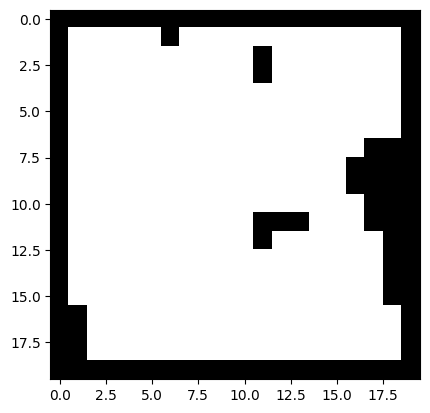

In [26]:
plt.imshow(obstacle_grid_main, cmap="gray_r")